# YOUR PROJECT TITLE

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **data analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `dataproject.py` file includes a function which can be used multiple times in this notebook.

Imports and set magics:

In [297]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from matplotlib_venn import venn2

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
#import dataproject


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read and clean data

## Dataset 1: World Bank development indicators

We import data from the worldbanks databanks world development indicators. We import the data through a csv-file. The csv-file contains data for all 217 countries in the world. The included variables are GDP per capita in 2019, PPP current international $, life expectancy at birth in 2019, and population in 2019. 

In [298]:
wd = pd.read_csv('WorldData.csv') # Import data
wd.head() # Inspect data

,Country Name,Country Code,Series Name,Series Code,2019 [YR2019]
0,Afghanistan,AFG,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD,2167.70411054404
1,Afghanistan,AFG,"Mortality rate, under-5 (per 1,000 live births)",SH.DYN.MORT,59.9
2,Afghanistan,AFG,"Population, total",SP.POP.TOTL,37769499
3,Afghanistan,AFG,"Life expectancy at birth, total (years)",SP.DYN.LE00.IN,63.565
4,Albania,ALB,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD,14407.3656909018


We clean out dataset. We being by deleting the colums we dont need, which is country code and series code. 

In [299]:
# We drop the following colums: country code and series code
drop_these = ['Country Code', 'Series Code']
wd.drop(drop_these, axis=1, inplace=True)
wd.rename(columns = {'Country Name':'country', 'Series Name':'index', '2019 [YR2019]':'val'}, inplace=True)
wd.head()

,country,index,val
0,Afghanistan,"GDP per capita, PPP (current international $)",2167.70411054404
1,Afghanistan,"Mortality rate, under-5 (per 1,000 live births)",59.9
2,Afghanistan,"Population, total",37769499
3,Afghanistan,"Life expectancy at birth, total (years)",63.565
4,Albania,"GDP per capita, PPP (current international $)",14407.3656909018


We want to reshape the data set, in order to have all the information for a country in one row. 

In [300]:
#
wd = wd.pivot_table(index='country', columns='index', values='val', aggfunc='sum').reset_index()
wd.head()


index,country,"GDP per capita, PPP (current international $)","Life expectancy at birth, total (years)","Mortality rate, under-5 (per 1,000 live births)","Population, total"
0,Afghanistan,2167.70411054404,63.565,59.9,37769499
1,Albania,14407.3656909018,79.282,9.4,2854191
2,Algeria,12118.0045004936,76.474,23.5,42705368
3,American Samoa,..,..,..,47321
4,Andorra,..,..,3,76343


We change the variable names, such that there are no white spaces in columnames.

In [301]:
var_dict = {} # var is for variable
var_dict['GDP per capita, PPP (current international $)'] = 'gdp_per_cap'
var_dict['Life expectancy at birth, total (years)'] = 'life_exp'
var_dict['Mortality rate, under-5 (per 1,000 live births)'] = 'child_mort'
var_dict['Population, total'] = 'popl'

wd.rename(columns = var_dict,inplace=True)
wd.head()


index,country,gdp_per_cap,life_exp,child_mort,popl
0,Afghanistan,2167.70411054404,63.565,59.9,37769499
1,Albania,14407.3656909018,79.282,9.4,2854191
2,Algeria,12118.0045004936,76.474,23.5,42705368
3,American Samoa,..,..,..,47321
4,Andorra,..,..,3,76343


For the sake of future analysis we only want to keep data, where we have values for all variables. If there is not avaliable data for either gdp_per_cap, life_exp or popl we delete the observation. This is the case for 32 countries in our dataset.

In [302]:
# create logical index
I = wd.gdp_per_cap == '..'
I |= wd.life_exp == '..'
I |= wd.child_mort == '..'
I |= wd.popl == '..'
wd.loc[I, :]
# print number of cases to delete
print(sum(I))
# keep all other observations
wd = wd.loc[I == False]
wd.head()

37


index,country,gdp_per_cap,life_exp,child_mort,popl
0,Afghanistan,2167.70411054404,63.565,59.9,37769499
1,Albania,14407.3656909018,79.282,9.4,2854191
2,Algeria,12118.0045004936,76.474,23.5,42705368
5,Angola,6881.07624117546,62.448,75,32353588
6,Antigua and Barbuda,24007.8684845165,78.691,6.6,92117


We see that American Samoa and Andorra now is deleted because of missing values. The same goes for the other 35 observations.

We see that there is a problem regarding the type of the variables. The dataframe has stored all the variabels as 'objects'.

In [303]:
wd.info() #We check the variable types in the dataframe

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180 entries, 0 to 216
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   country      180 non-null    object
 1   gdp_per_cap  180 non-null    object
 2   life_exp     180 non-null    object
 3   child_mort   180 non-null    object
 4   popl         180 non-null    object
dtypes: object(5)
memory usage: 8.4+ KB


We change the variable types to the correct ones, so we can work with them.

In [304]:
wd.country = wd.country.astype('string')
wd.gdp_per_cap = wd.gdp_per_cap.astype(float)
wd.life_exp = wd.life_exp.astype(float)
wd.child_mort = wd.child_mort.astype(float)
wd.popl = wd.popl.astype(float)

wd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180 entries, 0 to 216
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country      180 non-null    string 
 1   gdp_per_cap  180 non-null    float64
 2   life_exp     180 non-null    float64
 3   child_mort   180 non-null    float64
 4   popl         180 non-null    float64
dtypes: float64(4), string(1)
memory usage: 8.4 KB


We change the population size to be in millions

In [305]:
wd.popl = wd.popl*(10**-6)
wd.head()

index,country,gdp_per_cap,life_exp,child_mort,popl
0,Afghanistan,2167.704111,63.565,59.9,37.769499
1,Albania,14407.365691,79.282,9.4,2.854191
2,Algeria,12118.004500,76.474,23.5,42.705368
5,Angola,6881.076241,62.448,75.0,32.353588
6,Antigua and Barbuda,24007.868485,78.691,6.6,0.092117


## Dataset 2: Continents

We import another dataset containing the continent for each contry.

In [306]:
cd = pd.read_csv('ContinentData.csv') # Import data
cd.head() # Inspect data

,Entity,Code,Year,Continent
0,Abkhazia,OWID_ABK,2015,Asia
1,Afghanistan,AFG,2015,Asia
2,Akrotiri and Dhekelia,OWID_AKD,2015,Asia
3,Albania,ALB,2015,Europe
4,Algeria,DZA,2015,Africa


In [307]:
# We drop the following colums: Code and Year
drop_cont = ['Code', 'Year']
cd.drop(drop_cont, axis=1, inplace=True)
cd.rename(columns = {'Entity':'country', 'Continent':'continent'}, inplace=True)

cd.country = cd.country.astype('string')
cd.continent = cd.continent.astype('string')

cd.head()
cd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   country    285 non-null    string
 1   continent  285 non-null    string
dtypes: string(2)
memory usage: 4.6 KB


## Merge data sets

We merge the two datasets wd and cd

In [308]:
#

wd_cont = pd.merge(wd, cd, how = 'inner', on = 'country')
print(f'Number of countries ={len(wd_cont.country.unique())}')

Number of countries =161


Our merge have further deleted 19 countries. We now have all the information we want for 161 countries.

## Preston curve

After cleaning and sorting out the data, we can now explore it.

We want to show the relationship between income and life expentancy for all countries which contains data for both. Using a scatterplot we get the following relationship.

Text(0, 0.5, 'Life expantancy at birth, 2019')

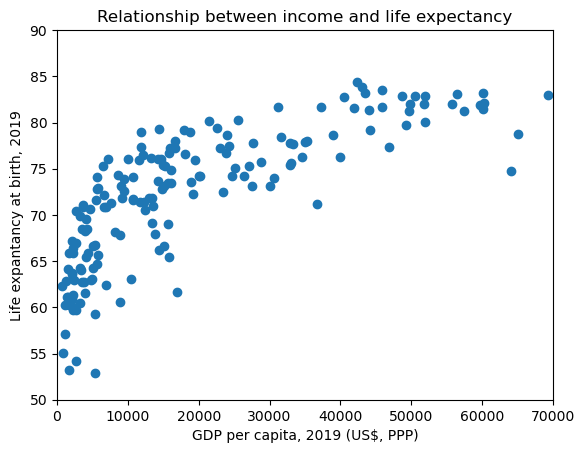

In [309]:
fig = plt.figure() #Create figure
ax = fig.add_subplot(1,1,1) #Create plot
plt.scatter(wd.gdp_per_cap, wd.life_exp)

#Alterations to figure
ax.set(xlim=(0, 70000), ylim=(50, 90))
ax.set_title('Relationship between income and life expectancy')
ax.set_xlabel('GDP per capita, 2019 (US$, PPP)')
ax.set_ylabel('Life expantancy at birth, 2019')


We have now show the relationship between the income and life expectancy with a simple figure. Using our learned skills we will make the figure look nice and more readable.

We create a dictionary where we asign a colour to each continent

In [310]:
colours = {
    'Africa':'purple',
    'Asia':'yellow',
    'Europe':'green',
    'North America':'blue',
    'Oceania':'red',
    'South America':'orange'
}

In [314]:
wd_cont['colour'] = ''
for key, value in colours.items():
    wd_cont.colour.append(key, value)

wd_cont.head()

/var/folders/02/k6_n1tbx3dx3n9lwnsrf_5qr0000gp/T/ipykernel_38523/575453394.py:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  wd_cont.colour.append(key, value)


TypeError: cannot concatenate object of type '<class 'str'>'; only Series and DataFrame objs are valid

In [ ]:
wd_cont = wd_cont.append(colours, ignore_index=True)
wd_cont.head()

In [ ]:
fig = plt.figure() #Create figure
ax = fig.add_subplot(1,1,1) #Create plot
plt.scatter(wd.gdp_per_cap, wd.life_exp, s = wd.popl, c = colours, alpha=0.5) #We add s equal to the population size

#Alterations to figure
ax.set(xlim=(0, 70000), ylim=(50, 90))
ax.set_title('Relationship between income and life expectancy')
ax.set_xlabel('GDP per capita, 2019 (US$, PPP)')
ax.set_ylabel('Life expantancy at birth, 2019')

#Further alterations
#tick_val = [10000:70000]
#tick_lab = ['$10.000', 20000, 30000, 40000, 50000, 60000, 70000]



## Explore each data set

In order to be able to **explore the raw data**, you may provide **static** and **interactive plots** to show important developments 

Now you create combinations of your loaded data sets. Remember the illustration of a (inner) **merge**:

To show that we know how to merge datasets, we merge the previously importet data (WorldData) with child mortality (<5 per 1000 live births) from the same source world bank data.

In [ ]:
plt.figure(figsize=(15,7))
v = venn2(subsets = (4, 4, 10), set_labels = ('Data X', 'Data Y'))
v.get_label_by_id('100').set_text('dropped')
v.get_label_by_id('010').set_text('dropped' )
v.get_label_by_id('110').set_text('included')
plt.show()

Here we are dropping elements from both data set X and data set Y. A left join would keep all observations in data X intact and subset only from Y. 

Make sure that your resulting data sets have the correct number of rows and columns. That is, be clear about which observations are thrown away. 

**Note:** Don't make Venn diagrams in your own data project. It is just for exposition. 

# Analysis

To get a quick overview of the data, we show some **summary statistics** on a meaningful aggregation. 

MAKE FURTHER ANALYSIS. EXPLAIN THE CODE BRIEFLY AND SUMMARIZE THE RESULTS.

# Conclusion

ADD CONCISE CONLUSION.